Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import numpy as np
import pandas as pd
import os
import cv2

## Labels

In [2]:
labels = os.listdir(r"train")

In [3]:
labels

['Closed', 'no_yawn', 'Open', 'yawn']

## Visualize A random image

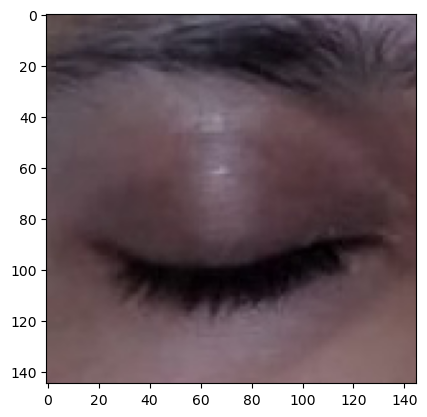

In [4]:
import matplotlib.pyplot as plt
plt.imshow(plt.imread(r"train/Closed/_0.jpg"))

## Image array

In [7]:
a = plt.imread(r"train/yawn/10.jpg")

## Image shape

In [8]:
a.shape

(480, 640, 3)

## Visualize yawn image(Background is unnecessary. We need only face image array)


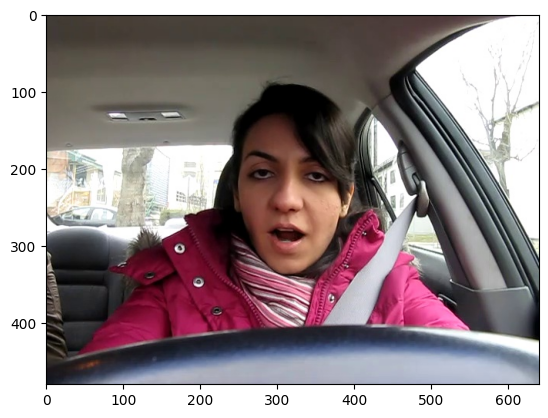

In [9]:
plt.imshow(plt.imread(r"train/yawn/10.jpg"))

## Take only face(For yawn and not_yawn)

In [10]:
def face_for_yawn(direc=r"train", face_cas_path=r"data/haarcascade_frontalface_default.xml"):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no


yawn_no_yawn = face_for_yawn()

0
1


## For Closed and Open eye

In [11]:
def get_data(dir_path=r"train", face_cas=r"data/haarcascade_frontalface_default.xml", eye_cas=r"haarcascade.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data

In [12]:
data_train = get_data()

2
3


## Extend data and Convert array

In [13]:
def append_data():
#     total_data = []
    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data)
    return np.array(yaw_no)

## New variable to store

In [14]:
new_data = append_data()

0
1
2
3


<ipython-input-13-be15ac3ad549>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(yaw_no)


## Separate label and features

In [15]:
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)

## Reshape the Array

In [16]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

## LabelBinarizer

In [17]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

## Label array

In [18]:
y = np.array(y)

## Train Test split

In [19]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

## Length of X_test

In [20]:
len(X_test)

585

## Import some dependencies

In [5]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

: 

## Data Augmentation

In [22]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)


#train_generator = tf.data.Dataset.from_tensor_slices((X_train, y_train))
#test_generator = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

# Model

In [23]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(145,145,3)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 143, 143, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2  (None, 71, 71, 256)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 34, 34, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 64)        0

In [24]:
history = model.fit(train_generator, epochs=50, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/50
43/43 [==============================] - 25s 265ms/step - loss: 1.1574 - accuracy: 0.4850 - val_loss: 0.6700 - val_accuracy: 0.7043
Epoch 2/50
43/43 [==============================] - 9s 219ms/step - loss: 0.5557 - accuracy: 0.7770 - val_loss: 0.4494 - val_accuracy: 0.8188
Epoch 3/50
43/43 [==============================] - 8s 185ms/step - loss: 0.4117 - accuracy: 0.8225 - val_loss: 0.3912 - val_accuracy: 0.8462
Epoch 4/50
43/43 [==============================] - 8s 181ms/step - loss: 0.3576 - accuracy: 0.8452 - val_loss: 0.5059 - val_accuracy: 0.7658
Epoch 5/50
43/43 [==============================] - 10s 221ms/step - loss: 0.3550 - accuracy: 0.8452 - val_loss: 0.2219 - val_accuracy: 0.9197
Epoch 6/50
43/43 [==============================] - 9s 201ms/step - loss: 0.3063 - accuracy: 0.8687 - val_loss: 0.2823 - val_accuracy: 0.8957
Epoch 7/50
43/43 [==============================] - 8s 181ms/step - loss: 0.2930 - accuracy: 0.8635 - val_loss: 0.2052 - val_accuracy: 0.9162
Epoc

## History

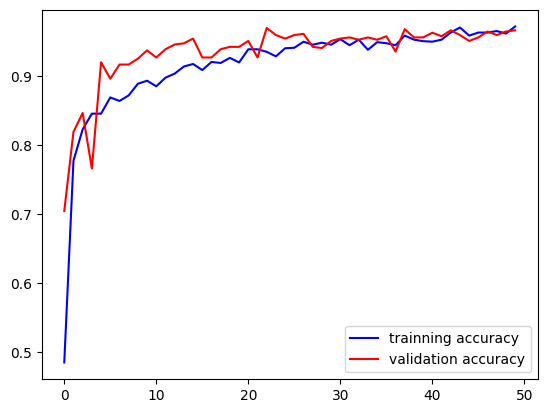

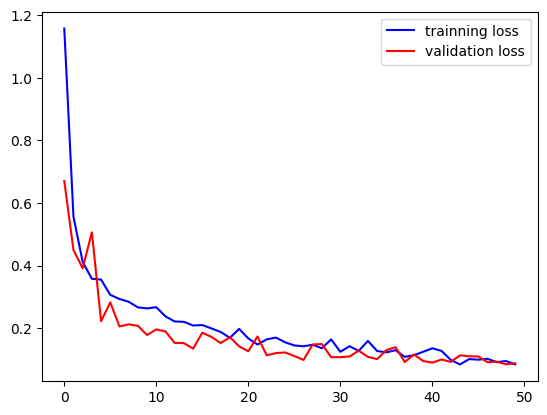

In [25]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

## Save Model

In [26]:
# model.save("drowiness_new7.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
# model.save("drowiness_new7.model")

# Prediction

In [29]:
prediction = model.predict(X_test)

19/19 [==============================] - 1s 29ms/step


In [31]:
prediction


array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 4.2988535e-13, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 4.5270904e-28]],
      dtype=float32)

# classification report

In [32]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]

In [34]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis=1), np.argmax(prediction, axis =1), target_names=labels_new))

              precision    recall  f1-score   support

        yawn       0.83      0.75      0.79        69
     no_yawn       0.75      0.96      0.84        77
      Closed       0.97      0.84      0.90       210
        Open       0.92      0.96      0.94       229

    accuracy                           0.89       585
   macro avg       0.86      0.88      0.87       585
weighted avg       0.90      0.89      0.89       585



# predicting function

In [36]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]
IMG_SIZE = 145
def prepare(filepath, face_cas="data/haarcascade_frontalface_default.xml"):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

model = tf.keras.models.load_model("./drowiness_new7.h5")

# Prediction
## 0-yawn, 1-no_yawn, 2-Closed, 3-Open

In [39]:
# prepare("../input/drowsiness-dataset/train/no_yawn/1068.jpg")
prediction = model.predict([prepare(r"train/no_yawn/1067.jpg")])
np.argmax(prediction)

1/1 [==============================] - 1s 669ms/step


1

In [40]:
prediction = model.predict([prepare(r"train/Closed/_101.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 28ms/step


2

In [41]:
prediction = model.predict([prepare(r"train/Closed/_104.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 74ms/step


2

In [42]:
prediction = model.predict([prepare(r"train/yawn/12.jpg")])
np.argmax(prediction)


1/1 [==============================] - 0s 21ms/step


0